In [1]:
from xraycam.nbinit import *
camcontrol.set_detector('zwo')

In [2]:
from xraycam.camalysis import *

In [3]:
class Monitor:
    def __init__(self, *args, transpose = True, vmax = 150, rebin = 1, **kwargs):
        self.run = camcontrol.DataRun(*args, **kwargs)
        self.vmax = vmax
        self.rebin = rebin

    def frame(self):
        return self.run.get_frame()
    
    def update(self):
        self.run.show(vmax = self.vmax)
        self.run.plot_lineout(rebin = self.rebin)
        self.frame().plot_histogram(xmin = 0, xmax = self.vmax)
        
    def stop(self):
        self.run.stop()

In [5]:
GaP0 = Monitor(threshold = 2, window_min = 104, window_max = 114, photon_value = 110,
            run_prefix = 'GaP0.9.16',htime="5m")

Loaded from cache.


In [6]:
GaP1 = Monitor(threshold = 2, window_min = 104, window_max = 114, photon_value = 110,
            run_prefix = 'GaP1.9.16',htime="5m")

starting acquisition


In [24]:
GaP2 = Monitor(threshold = 2, window_min = 104, window_max = 114, photon_value = 110,
            run_prefix = 'GaP2.9.16',htime="5m")

starting acquisition


In [70]:
GaP3 = Monitor(threshold = 2, window_min = 104, window_max = 114, photon_value = 110,
            run_prefix = 'GaP3.9.16')

In [6]:
GaP4 = Monitor(threshold = 2, window_min = 104, window_max = 114, photon_value = 110,
            run_prefix = 'GaP4.9.16')

In [5]:
plot_with_energy_scale(GaP0.run,2015,known_bin=None,label='GaP',rebin=2,
                           xrange=[600,1200],show=False,calcfwhm=True,peaknormalize=True)
plt.show()

# Playing with parabolic fitting code

In [5]:
zns0 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'zns0.contd.9.15')

Loaded from cache.


In [5]:
from scipy.ndimage.filters import gaussian_filter as gfilt

def parabolic_sort(a, b, shape = (1024, 1280)):
    """
    Returns: z, (rowsort, colsort)
    
    z : 2d numpy array of shape `shape` with values x**2 + b * x + c,
    where x is row index.
    rowsort : sequence of row indices that sort z
    colsort : sequence of column indices that sort z
    """
    x, y = np.indices(shape, dtype = 'int')
    z = ((a * (x**2)) + (b * x) + y)
    return z, np.unravel_index(
                np.argsort(z.ravel()), z.shape)

def quadfit(arr2d, smooth = 0):
    """
    Return the second- and first-order coefficients for a parabolic
    fit to array of center of mass values of the rows of arr2d.
    """
    filtered = gfilt(arr2d, smooth)
    y = center_of_masses(filtered)# - np.percentile(filtered, 1))
    x = np.arange(len(y))
    good = np.where(np.isfinite(y))[0]
    a, b, c, = np.polyfit(x[good], y[good], 2)
    # For some reason a factor of -1 is needed
    return -a, -b, -c

def get_parabolic_lineout(arr2d, nbins = None):
    """Return lineout taken using parabolic bins"""
    a, b, _ = quadfit(arr2d)
    num_rows, num_cols = arr2d.shape
    if nbins is None:
        nbins = num_cols
    def chunks():
        """Return array values grouped into chunks, one per bin"""
        increment = int(num_rows * (num_cols/nbins))
        _, sort_indices = parabolic_sort(a, b, arr2d.shape)
        sort_data = arr2d[sort_indices].ravel()
        return [sort_data[i:i + increment] for i in range(0, len(sort_data), increment)]
    return np.array(list(map(np.sum, chunks())))

psurface, sort_indices = parabolic_sort(-7.23224111e-05,  8.57453753e-02)

import matplotlib.pyplot as mplt
def plot_parabolas(arr2d, interval = 10):
    a, b, _ = quadfit(arr2d)
    a, b = -a, -b
    x = np.arange(arr2d.shape[0])
    parabolas = [a * x**2 + b * x + c for c in range(0, arr2d.shape[1], interval)]
    [mplt.plot(p, x) for p in parabolas]
    
# We exclude the top and bottom of the frame to avoid boundary artifacts
#exclude_region = 0
#arr2d = salpha_full_analyzer.get_array()[250:-250, 500:800]

def normlineout(dat):
    lineout = np.sum(dat, axis = 0)
    return lineout/np.max(lineout)

def dofit(arr2d):

    y = center_of_masses(arr2d)
    x = np.arange(len(y))
    plt.plot(x, y, label = 'CM lineout')

    a, b, c = quadfit(arr2d)
    plt.plot(x, -a * x**2 - b * x - c)
    plt.show()

    # Also the 2d array overlaid with some of the bin-defining parabolas
    mplt.imshow(arr2d, vmax = 450)
    plot_parabolas(arr2d, interval = 15)
    mplt.show()
    
    plt.plot(get_parabolic_lineout(arr2d), label = 'parabolic lineout')
    #col_lineout = normlineout(arr2d)
    plt.plot(np.sum(arr2d, axis = 0), label = 'column lineout')
    plt.show()

    print(a, b, c) 
    
    return get_parabolic_lineout(arr2d)

<IPython.core.display.Javascript object>


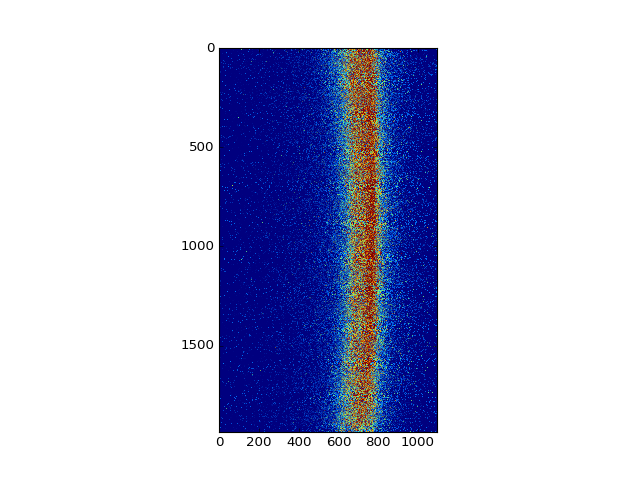

In [6]:
GaP0.run.show(vmax=450)

<IPython.core.display.Javascript object>


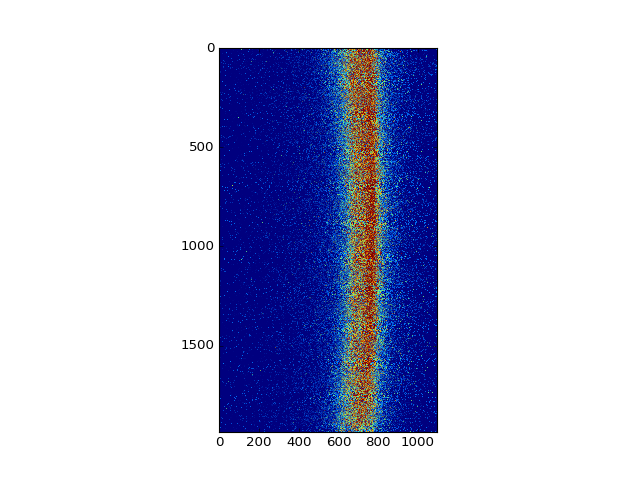

In [26]:
mplt.imshow(np.transpose(GaP0.run.get_array()[::,::-1]),vmax=450)
mplt.show()

In [7]:
def _reorient_array(arr2d):
    """Take output from the get_array() method for dataruns from the new camera,
    and reorient them to match what our usual analysis code expects."""
    return np.transpose(arr2d[::,::-1])

In [8]:
quadfit(_reorient_array(GaP0.run.get_array()))

(3.5046104767225768e-05, -0.063927724845578182, -694.02811864894363)

In [138]:
np.mean(center_of_masses(_reorient_array(GaP0.run.get_array())))

712.12672286089787

In [160]:
def quadfit(arr2d, smooth = 5):
    """
    Return the second- and first-order coefficients for a parabolic
    fit to array of center of mass values of the rows of arr2d.
    """
    y = gfilt(center_of_masses(arr2d), smooth)# - np.percentile(filtered, 1)) *Note: changed gfilt to act on y instead of on 2d array.  Seems to produce better parabolas.
    x = np.arange(len(y))
    good = np.where(np.isfinite(y))[0]
    a, b, c, = np.polyfit(x[good], y[good], 2)
    # For some reason a factor of -1 is needed
    return -a, -b, -c

def get_parabolic_lineout(arr2d, nbins = None, fitregion = 'cm' , fitregionx = [0,-1], fitregiony = [0,-1],yrange=[0,-1],**kwargs):
    """Return lineout taken using parabolic bins"""
    # Fit only to specific region
    if fitregion != 'cm':
        a, b, _ = quadfit(arr2d[fitregiony[0]:fitregiony[1],fitregionx[0]:fitregionx[1]])
    else: 
        # Fit around center of mass to get better parabolas
        cm = np.mean(center_of_masses(arr2d))
        a, b, _ = quadfit(arr2d[fitregiony[0]:fitregiony[1],int(cm-150):int(cm+150)])
    if yrange != [0,-1]: 
        # crop the region in the lineout, but with parabolic parameters from the (possibly) different fitregion
        arr2d = arr2d[yrange[0]:yrange[1],:]
    num_rows, num_cols = arr2d.shape
    if nbins is None:
        nbins = num_cols
    def chunks():
        """Return array values grouped into chunks, one per bin"""
        increment = int(num_rows * (num_cols/nbins))
        _, sort_indices = parabolic_sort(a, b, arr2d.shape)
        sort_data = arr2d[sort_indices].ravel()
        return [sort_data[i:i + increment] for i in range(0, len(sort_data), increment)]
    return np.array(list(map(np.sum, chunks())))

In [47]:
import matplotlib.pyplot as mplt
def plot_parabolas(arr2d, interval = 10):
    a, b, _ = quadfit(arr2d)
    a, b = -a, -b
    x = np.arange(arr2d.shape[0])
    parabolas = [a * x**2 + b * x + c for c in range(0, arr2d.shape[1], interval)]
    [mplt.plot(p, x) for p in parabolas]

In [90]:
def dofit_will(arr2d,fitregionx = [0,-1], fitregiony = [0,-1],cropregionx = [0,-1], cropregiony = [0,-1]):

    y = center_of_masses(arr2d[fitregiony[0]:fitregiony[1],fitregionx[0]:fitregionx[1]])
    x = np.arange(len(y))
    plt.plot(x, y, label = 'CM lineout')

    a, b, c = quadfit(arr2d[fitregiony[0]:fitregiony[1],fitregionx[0]:fitregionx[1]])
    plt.plot(x, -a * x**2 - b * x - c)
    plt.show()

    # Also the 2d array overlaid with some of the bin-defining parabolas
    #mplt.imshow(arr2d, vmax = 450)
    mplt.imshow(arr2d[fitregiony[0]:fitregiony[1],fitregionx[0]:fitregionx[1]], vmax = 450)
    plot_parabolas(arr2d[fitregiony[0]:fitregiony[1],fitregionx[0]:fitregionx[1]], interval = 15)
    mplt.show()
    
    plt.plot(get_parabolic_lineout(arr2d,fitregionx=fitregionx,fitregiony=fitregiony,cropregionx=cropregionx,cropregiony=cropregiony), label = 'parabolic lineout')
    #col_lineout = normlineout(arr2d)
    plt.plot(np.sum(arr2d[cropregiony[0]:cropregiony[1],cropregionx[0]:cropregionx[1]], axis = 0), label = 'column lineout')
    plt.show()

    print(a, b, c) 
    
    return

In [8]:
cds0 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'cds0.contd.9.15')

Loaded from cache.


<IPython.core.display.Javascript object>


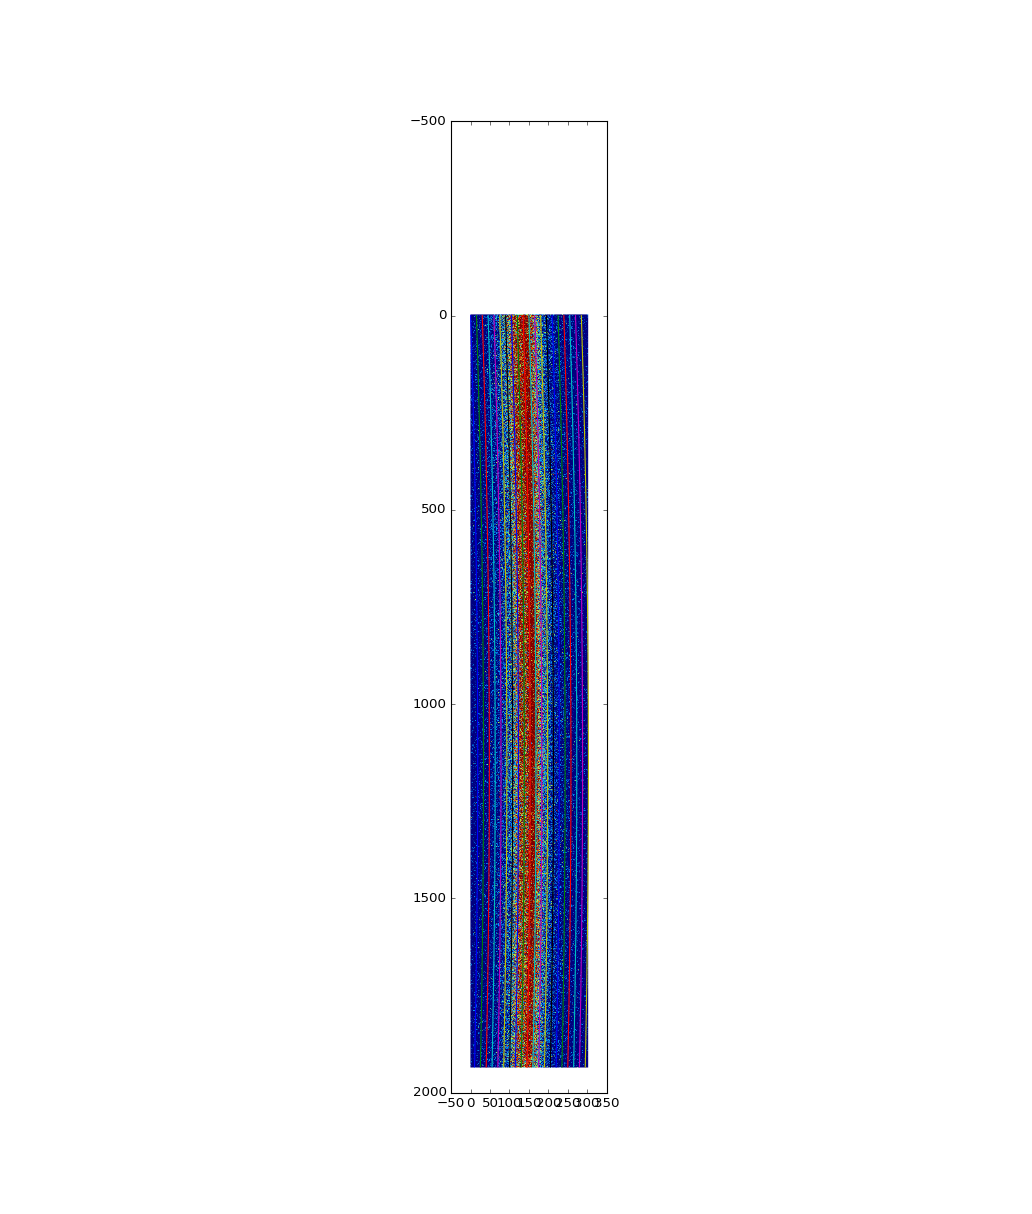

1.35592235081e-05 -0.0314464112642 -130.120711706


In [94]:
_ = dofit_will(_reorient_array(cds0.run.get_array()),fitregionx=[200,500],fitregiony=[0,-1],cropregiony=[400,1200])

In [21]:
GaP0.run.plot_lineout()

array([  11.        ,   36.73636364,   46.96363636, ...,  112.52727273,
        120.25454545,   97.63636364])

<IPython.core.display.Javascript object>


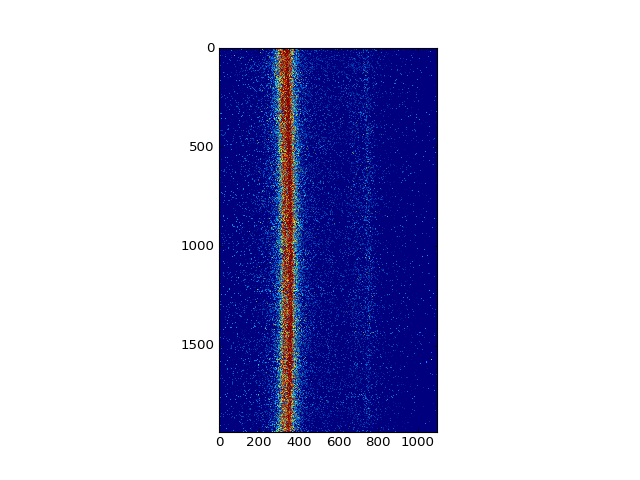

In [95]:
cds0.run.show(vmax=450)

In [124]:
def plot_parabolic_lineout(arr2d, *args, show=False,peaknormalize=True, **kwargs):
    lineout = get_parabolic_lineout(arr2d,**kwargs)
    if peaknormalize == True:
        lineout=lineout/max(lineout)
    plt.plot(*add_energy_scale(lineout,*args, **kwargs),label='parabolic')
    if show == True:
        plt.show()

In [132]:
plot_parabolic_lineout(_reorient_array(cds0.run.get_array()),2300,fitregionx=[200,500],fitregiony=[0,-1],cropregiony=[0,-1],label='parabolic')
plot_with_energy_scale(cds0.run,2300,known_bin=None,label='column',rebin=1,
                           xrange=[0,-1],show=False,calcfwhm=True,peaknormalize=True)
plt.show()

In [161]:
plot_parabolic_lineout(_reorient_array(cds0.run.get_array()),2300,fitregion = '',fitregionx=[1,-1],fitregiony=[0,-1],label='parabolic',show=False)
plot_parabolic_lineout(_reorient_array(cds0.run.get_array()),2300,fitregion = 'cm',cropregiony=[400,1200],label='parabolic',show=False)
plt.show()

# Made commit after adding parabolic kwarg to plot_with_energy_scale function

In [18]:
plot_with_energy_scale(cds0.run,2300,known_bin=None,label='column',rebin=1,
                           xrange=[0,-1],yrange = [0,-1],show=False,calcfwhm=True,peaknormalize=True)
plot_with_energy_scale(cds0.run,2300,known_bin=None,label='parabola',rebin=1,
                           xrange=[0,-1],yrange = [0,-1], show=False,calcfwhm=True,peaknormalize=True,parabolic=True)
plt.show()

In [7]:
cropping_tool(GaP0.run,200,rebin=1)